Before running the spot detection notebook, run the first notebook, "HOX_Spot_detection_part_1.ipynb'.

In this notebook we will detect the fish spots using a semi automatic method called BIGFISH.

WARNING:  run this notebook in the usual environment 'base_env_apifish'.


23/05/25     Jacques Bourg @ Florian Muller lab. Institut Pasteur.

<img src="./HOX_pipeline.png" alt="HOX pipeline" width="1200" height="477">

In [1]:
import os
import sys
import numpy as np
from pathlib import Path
import skimage.io as io
import napari

import ipywidgets as widgets
from IPython.display import display

In [2]:
%load_ext autoreload
%autoreload 2

base_dir = Path("../../src").resolve()
sys.path.append(str(base_dir))
sys.path.append(str(base_dir / "utils"))
sys.path.append(str(base_dir / "detection_fish"))
sys.path.append(str(base_dir / "segmentation"))

from utils.parameters_tracking import Parameter_tracking as Track
from utils.file_handling import FileProcessor
from detection_fish.detect_fish_spots import DetectionPipeline
from detection_fish.thresh_big_fish_napariV3 import SpotsThresholding 
from segmentation.refine_seg import Segmentation

tk  = Track()
det = DetectionPipeline()
sg  = Segmentation()
fp  = FileProcessor()

In [3]:
var = str(Path('../Analysis'))
batch_folders = os.listdir(var)
dropdown = widgets.Dropdown(options=batch_folders, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('.gitkeep', 'test'), …

In [4]:
n         = np.where(np.array(batch_folders) == dropdown.value)[0][0]
file_path = str(Path(var) / Path(batch_folders[n]) / Path(batch_folders[n] +'.json'))
constants = tk.load_json(file_path)
batch_name= constants['BATCH_NAME']; print(batch_name)

test


In [5]:
modalities = constants['MODALITIES']
dropdown2 = widgets.Dropdown(options=modalities, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown2)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('EXPERIMENT', 'CONTRO…

In [6]:
n2       = np.where(np.array(modalities) == dropdown2.value)[0][0]
modality = modalities[n2]; print(modality)

EXPERIMENT


In [7]:
channel_cell = constants['CHANNELS'] # (Doesn't make sense to select DAPI)
dropdown3    = widgets.Dropdown(options=channel_cell, description='Select:', layout=widgets.Layout(width='auto', min_width='150px')); display(dropdown3)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('DAPI', 'FISH0', 'FIS…

In [8]:
n3     = np.where(np.array(channel_cell) == dropdown3.value)[0][0]
chan_c = channel_cell[n3]; print(chan_c)

FISH0


In [9]:
batch_fish = constants[f'BATCH_{modality}_{chan_c}']; print(batch_fish);

['../Acquisition/test/EXPERIMENT/FISH0/HM40-J3DIFF-NT6h-HOXA10-620_HOXC8-520-1002-1_FISH0.tif', '../Acquisition/test/EXPERIMENT/FISH0/HM40-J3DIFF-NT24h-HOXA10-620_HOXC8-520-1005-1_FISH0.tif', '../Acquisition/test/EXPERIMENT/FISH0/HM40-J3DIFF-NT48h-HOXA10-620_HOXC8-520-1008-1_FISH0.tif', '../Acquisition/test/EXPERIMENT/FISH0/HM40-J3DIFF-GDF6h-HOXA10-620_HOXC8-522-1_FISH0.tif', '../Acquisition/test/EXPERIMENT/FISH0/HM40-J3DIFF-GDF24h-HOXA10-620_HOXC8-525-1_FISH0.tif', '../Acquisition/test/EXPERIMENT/FISH0/HM40-J3DIFF-GDF48h-HOXA10-620_HOXC8-528-1_FISH0.tif', '../Acquisition/test/EXPERIMENT/FISH0/HM40-J3DIFF-FGFGDF6h-HOXA10-620_HOXC8-531-1_FISH0.tif', '../Acquisition/test/EXPERIMENT/FISH0/HM40-J3DIFF-FGFGDF24h-HOXA10-620_HOXC8-534-1_FISH0.tif', '../Acquisition/test/EXPERIMENT/FISH0/HM40-J3DIFF-FGFGDF48h-HOXA10-620_HOXC8-537-1_FISH0.tif']


In [10]:
spots_folder = Path(f'../Analysis/{batch_name}/{modality}/{chan_c}/spots')
if not spots_folder.exists():
    spots_folder.mkdir(parents=True)
print(spots_folder)

spots_bigfish_folder = Path(f'../Analysis/{batch_name}/{modality}/{chan_c}/spots/BIGFISH')
if not spots_bigfish_folder.exists():
    spots_bigfish_folder.mkdir(parents=True)
print(spots_bigfish_folder)

../Analysis/test/EXPERIMENT/FISH0/spots
../Analysis/test/EXPERIMENT/FISH0/spots/BIGFISH


Adjust the threshold by eye. Often there is some kind of inflexion point in the counts vs threshold curve at which the noise
 distribution and the signal distribution overlap.
When one doesn't see this point look for a point in the noisy regime (left) which the derivative decreases in absolute value.  

In [29]:
dots_ufish_path     = constants[f'DOTS_UFISH_{modality}_{chan_c}_PATH']
format_spots        = constants["SPOTS_FORMAT"]

dict_ufish_dots     = fp.load_spots_distributed_files(dots_ufish_path, format=format_spots)
dict_ufish_dots_raw = {key + '_' + chan_c: (val[['Z','Y','X']].to_numpy() if 'Z' in val.columns else val[['Y','X']].to_numpy())
 for key, val in dict_ufish_dots.items()}

voxel_size_nm       = (108, 108)   # (z,y,x) or (y,x)  this parameter is important, you can check it's value opening the original files in fiji (Image/show info), or in the microscope metadata
object_radius_nm    = (432, 432)   # estimate this parameter by eye: number of pixels of spots diameter times the voxels size (respective Z, Y and X dimension)
im_dim              =  2           # change if needed  

batch_path          = [Path(el) for el in batch_fish]
dots_bigfish_path   = spots_bigfish_folder / f"dots_{modality}_{chan_c}_BIGFISH.npy"
thresh_bigfish_path = spots_bigfish_folder / f"thresh_{modality}_{chan_c}_BIGFISH.npy"

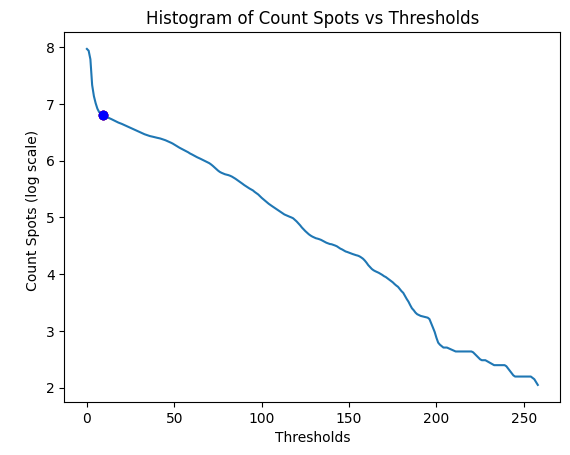

In [26]:
sth0 = SpotsThresholding(BATCH = batch_path, BATCH_NAME= batch_name, voxel_size_nm=voxel_size_nm, 
                         object_radius_nm=object_radius_nm, spots_other_method=dict_ufish_dots_raw, subtract_fish=False)
sth0.run()

After closing the app, pursue here.

In [27]:
# rename the keys in order to have as key only the base name
dict_dots = {}
for key, value in sth0.detected_spots.items():
    dict_dots['_'.join(key.split('_')[:-1])] = value

In [30]:
fp.save_spots_distributed_files(dots_bigfish_path, format_spots, dict_dots, im_dim)
np.save(thresh_bigfish_path, sth0.dict_thresh_spot)

In [31]:
exec(f"DOTS_BIGFISH_{modality}_{chan_c}_PATH = dots_bigfish_path", globals())
exec(f"THRESH_BIGFISH_{modality}_{chan_c}_PATH = thresh_bigfish_path", globals())

exec(f"VOXEL_SIZE_NM_BF_{modality}_{chan_c}_Z = voxel_size_nm[0]", globals())
exec(f"VOXEL_SIZE_NM_BF_{modality}_{chan_c}_YX = voxel_size_nm[1]", globals())
exec(f"OBJECT_RADIUS_NM_BF{modality}_{chan_c}_Z = object_radius_nm[0]", globals())
exec(f"OBJECT_RADIUS_NM_BF{modality}_{chan_c}_YX = object_radius_nm[1]", globals())

In [32]:
constants2 = tk.collect_constants()
tk.save_constants_and_commit_hash(constants2, batch_name, folder_path = Path(f"../Analysis/{batch_name}"))